
# 온라인 커뮤니티상의 인기글 제목의 특징


## 목차
1. 주제 선정 이유
2. 가설
3. 데이터 획득 및 가공
4. 분석 및 결과
5. 결론
6. 참고문헌

## 주제 선정 이유
- 우리 사회에 있어서, 특히 젊은 대학생들에게 있어서 인터넷에서의 콘텐츠 소비는 점점 증가하고 있다. 그리고 그런 콘텐츠 소비자들이 인터넷 콘텐츠를 선택해 사용하는 가장 큰 기준 중 하나는 <b>"제목"</b>이다. 콘텐츠 소비자들은 짧은 순간에 제목 혹은 썸네일을 보고 소비할 콘텐츠를 정하게 된다. 
- 그러나 소비자들은 단순히 <b>콘텐츠를 정하고 소비하는것에서 멈추지 않고, 스스로 또 다른 콘텐츠를 만들</b>어 낸다. 그리고 이들은 콘텐츠를 더 돋보이게 하기 위해서, <b>컨텐츠를 관통하고, 관심을 잘 끌수 있는 제목</b>을 지어내려 한다.
- 즉, 제목은 현대 사회에서 있어서 점점 영향력이 높아지고 있다고 할 수 있다. 따라서 이 레포트에서는 온라인 커뮤니티의 인기글들의 제목 데이터를 분석하고, 여기서 얻을 수 있는 여러 결과를 통해 <b>"인기"있는 제목의 특징</b>을 알아보고자 한다. 그리고 이를 통해서 <b>어떻게 해야 더 이끌리는 제목을 만들 수 있을지, 그리고 이것이 우리의 콘텐츠 소비에 어떤 점을 시사하는지</b>를 알아본다.

## 가설
1. 많은 인기글은, 일반적인 게시글의 제목에 비해서 상대적으로 짧은 제목을 가질 것이다.
2. 인기글 중에서, 제목에 한글 축약어(ex.ㅋㅋ, ㄹㅇ, ㄷㄷ)가 들어간 인기글은 다른 인기글에 비해 조회수가 상대적으로 높을 것이다.
3. 인기글 중에서, 제목에 수식언(관형사, 부사)의 빈도가 높은 인기글의 조회수가 상대적으로 높을 것이다.
4. 인기글의 제목에 사용된 명사들 중, 많이 사용된 상위 20개의 명사 중에는 부정적(자극적) 어휘가 다수일 것이다.

## 데이터 획득 및 가공
#### 1. 데이터 분석 대상 선정
- 데이터를 추출하기에 앞서서, 제목 데이터를 수집해 올 커뮤니티를 선정해야 한다. 이에 대만민국 온라인 커뮤니티 사이트의 트래픽 순위와 저명도를 참고하여, 후보를 에브리타임, 네이버 카페, 디시인사이드로 압축하였다.
- <b style="color:red;">에브리타임</b>의 경우, 자체적으로 제공되는 API가 없어 크롤링을 통해 데이터를 추출해야 한다. 또 특정 학교 구성원에게만 특정 게시글이 개방되고, 데이터 크롤링을 금지하고 있다. 따라서 __분석에서 제외하였다.__
- <b style="color:green">네이버 카페</b>의 경우, 카페 가입 절차를 밟아야 하는 시스템 특성상 데이터 추출이 어려웠다. 이에 __분석에서 제외하였다.__ 
- <b style="color:blue">디시인사이드</b>의 경우, 크롤링을 통해 데이터를 쉽게 확보 할 수 있다. 인기글의 기준은 좋아요/싫어요 와 같이 직관적으로 구분할 수 있다. 또 자체적으로 하위 주제 게시판(갤러리)마다 인기글을 선정, 보여주는 기능이 존재한다. 이를 종합하면, 데이터 분석 대상으로써는 가장 적합했고, 따라서 __분석 대상으로 선정했다.__

#### 2. 데이터 추출

In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import os
import csv
from openpyxl.cell.cell import ILLEGAL_CHARACTERS_RE

from wordcloud import WordCloud
from collections import Counter
from PIL import Image

from konlpy.tag import Okt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

- 먼저, 데이터를 크롤링 하기 위해 아래와 같이 코드를 작성하였다. 이때, 사이트에서 수집해 올 데이터는 <b>제목, 조회수, 추천수</b>이며, 추가로 <b>제목의 길이</b>도 덧붙였다.

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
#user-agent값 추가

fields = ["title", "views", "titleLen", "recommend_num"] #수집해 올 정보들

def get_from_site(URLS, nums, rec, minor): #(nums)페이지 만큼 불러오기, 한 페이지당 글 50개
    answer = [[], [], [], []]
    #----------------
    if rec: # 인기글을 가져 올 경우
        plused_adress = "&exception_mode=recommend"
    else:
        plused_adress = "&exception_mode=all"
        
    if minor: # 데이터를 가져오는 곳이 마이너 갤러리일 경우
        plused_adress2 = "mgallery/"
    else:
        plused_adress2 = ""
    #----------------
    for num in range(1, nums+1):
        URL = f"https://gall.dcinside.com/{plused_adress2}board/lists/?id={URLS}&page={num}{plused_adress}"
        found_source = requests.get(URL, headers=headers) # 요청
        found_bs = BeautifulSoup(found_source.text, "html.parser").find("tbody").find_all("tr", class_="ub-content us-post")
            
        for i in range(0, len(found_bs)):
            if minor: # 말머리 찾아오기 (정규 갤러리와 마이너 갤러리의 구조가 조금 다름)
                head_title = found_bs[i].find("td", "gall_subject").get_text()
            else:
                head_title = found_bs[i].find("td", "gall_num").get_text()
                
            if head_title=="공지" or head_title=="설문" or head_title=="AD" : #공지, 설문 글은 제외
                continue

            if not rec:
                    if found_bs[i].find("em", class_="icon_img icon_recomimg"):
                        continue
                    elif found_bs[i].find("em", class_="icon_img icon_recomtxt"):
                        continue
                    elif found_bs[i].find("em", class_="icon_img icon_btimebest"):
                        continue
                    elif found_bs[i].find("em", class_="icon_img icon_lbtimebest"):
                        continue
                    elif found_bs[i].find("em", class_="icon_img icon_hit"): #인기 게시글임을 보이는 아이콘을 가질 경우 제외
                        continue
            title = found_bs[i].find_all("a")[0].get_text() #게시글의 제목
            title = ILLEGAL_CHARACTERS_RE.sub(r'',title)
            views = found_bs[i].find_all("td", class_="gall_count")[0] #게시글의 조회수(str)
            title_len = len(title) #게시글의 제목 길이(공백 제외)
            rec_num = found_bs[i].find_all("td", class_="gall_recommend")[0] #게시글의 추천수(str)
            answer[0].append(title)
            answer[1].append(int(views.get_text()))
            answer[2].append(title_len)
            answer[3].append(int(rec_num.get_text()))
                
    return answer

def data_construction(Site:str, lenOfPage:int, recom:bool=True, minor:bool=False):
    if recom:
        identity = ""
    else:
        identity = "_general" # 인기글, 비인기글 파일 구분용 문자
        
    
    if os.path.isfile(f'{Site}{identity}.xlsx'): #만약 이미 수집한 데이터가 존재한다면
        temp_df = pd.read_excel(f'{Site}{identity}.xlsx') # 기존에 있던 csv 읽어오기
        temp_df.drop(["Unnamed: 0"], axis=1, inplace=True)
    else: # 이미 수집한 데이터가 존재하지 않는다면
        list1 = get_from_site(Site, lenOfPage, recom, minor)# lenOfPage수의 페이지 만큼의 게시글 불러오기
        temp_df = pd.DataFrame(zip(list1[0], list1[1], list1[2], list1[3]), columns = fields) #dataframe 구축
        print("scrapping completed!")
        temp_df
        temp_df.to_excel(f'{Site}{identity}.xlsx') # 새로 만든 dataframe 저장하기
    return temp_df

- 첫번쨰로, <b style="color:blue">인기글들의 제목 데이터 크롤링</b>을 진행하였다.
- 단, 사이트 전체 게시판(갤러리)의 게시글 제목을 분석하는 것은 어렵기에, 주제와 활성도를 고려하여 5개 정도의 갤러리에서 데이터를 확보했다. 대상은 프로그래밍, 군사, 미국 주식, 식물, mbti 갤러리 이다. (이때 사회적으로 물의를 일으켰거나, 논란의 여지가 있는 경우는 제외하였다.)
- 데이터는 합치지 않고 게시판 별로 각각 분리하였다. 이는 사이트 특성상, 게시판 마다 유저층과 성향이 다름을 고려하였다.

In [3]:
Site = [("programming", False), ("war", True), ("stockus", True), ("tree", False), ("mbti", True)]
        #게시판(갤러리) 고유 id, 뒤에 붙은 bool은 마이너 갤러리 형태인지를 표기함

page_num = 15
recommend_dfs = [data_construction(site_name, page_num, True, isminor) for site_name, isminor in Site] 
# 각각의 게시판에서 페이지 15개 만큼 데이터 추출

for i in range(5): # 데이터 전체 info
    recommend_dfs[i].info()

recommend_dfs[1].head() # 데이터 중 예시 1개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          750 non-null    object
 1   views          750 non-null    int64 
 2   titleLen       750 non-null    int64 
 3   recommend_num  750 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 23.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          749 non-null    object
 1   views          749 non-null    int64 
 2   titleLen       749 non-null    int64 
 3   recommend_num  749 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 23.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------

,title,views,titleLen,recommend_num
0,일본군이 악어에 학살당한 썰은 걍 역대급 구라임,582,26,16
1,특전사들 머리로 격파하는거는 꼭 막아야 되는.EU,411,27,10
2,유럽의회 탄약미사일생산지원법 446찬성표로 통과시킴,434,28,8
3,나토 내 탄약 모두 소진되기 전이라고 함,1721,22,11
4,미국이 Gepard 1.18억달러치를 우크라에 추가 구매해줌,666,33,8


- 다음으로, 인기글 기준에 미달한 게시글들의 제목 데이터를 스크래핑 했다.

In [4]:
general_dfs = [data_construction(site_name, page_num, False, isminor) for site_name, isminor in Site] 
# 각각의 게시판 전체글에서 페이지 15개(게시글 약 750개) 만큼 데이터 추출, 인기글은 제외

for i in range(5): #데이터 전체 info
    general_dfs[i].info()
general_dfs[1].head() #데이터 중 예시 1개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          747 non-null    object
 1   views          747 non-null    int64 
 2   titleLen       747 non-null    int64 
 3   recommend_num  747 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 23.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          712 non-null    object
 1   views          712 non-null    int64 
 2   titleLen       712 non-null    int64 
 3   recommend_num  712 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 22.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------

,title,views,titleLen,recommend_num
0,근데 문신하면 군대못감?,2,13,0
1,오늘도 금요일마다하는 러시아 안보리회의에서,1,24,0
2,자취하는 군붕이들 비빔밥 싸고 편하게 먹는법 알랴줌,9,28,0
3,우크라이나 6.25참전 국가 맞긴하지 ㅇㅇ,19,23,0
4,일본은 왜 자국산 탄도탄요격 체계를 안만들었을까,22,26,0


#### 3. 데이터 가공
- 가설 2, 3, 4를 파악하기 위해서 먼저 제목의 형태소 분석을 진행하였다. 한글 축약어의 개수, 수식언의 개수, 제목의 명사들을 기존 데이터에 저장하였다. 그리고 게시판 종류와 인기글 여부를 추가한 다음, 모든 데이터들을 하나의 데이터 프레임으로 묶어냈다.

In [5]:
okt = Okt()

In [6]:
def analyze_statement(temp_data): #데이터 가공
    length = len(temp_data)
    tagged_statements = [] #분석된 결과들을 저장
    for i in range(length):
        temp_title = str(temp_data.iloc[i, 0]) #제목 가져오기
        tagged_statements.append(okt.pos(temp_title)) #분석후 리스트에 저장
        
        
    is_particle_col = []
    for i in tagged_statements:
        for k in i:
            if k[1] == "KoreanParticle":
                is_particle_col.append("Y") #만약 KoreanParticle(ex.ㅋㅋ)이 있으면 Y, 아니면 N
                break
            else:
                is_particle_col.append("N")
        
    ad_num_count_col = []
    mod_col = []
    for i in tagged_statements:
        temp_count = 0
        temp_state = ""
        for k in i:
            if k[1] == "Noun": #만약 명사라면
                temp_state += okt.normalize(k[0]) + "@" # temp_state에 명사 저장, 구분자는 @
            elif k[1] == "Adjective" or k[1] == "Adverb" or k[1] == "Determiner": #만약 형용사, 부사, 관형사라면
                temp_count += 1 #개수 카운팅 +1
        else:
            temp_state = temp_state[:len(temp_state)-1]
        ad_num_count_col.append(temp_count)
        mod_col.append(temp_state) if temp_state != "" else mod_col.append("N") #없으면 N
        
    temp_df = pd.DataFrame(zip(is_particle_col, ad_num_count_col, mod_col), columns = ["isParticle", "adnum", "nouns"])
    temp_data = pd.concat([temp_data, temp_df], axis=1) #열-열 합병
    print("analyzing complete!")
    
    return temp_data #DataFrame 반환
 

In [7]:
for i in range(5): #분석
    recommend_dfs[i] = analyze_statement(recommend_dfs[i])

analyzing complete!
analyzing complete!
analyzing complete!
analyzing complete!
analyzing complete!


In [8]:
recommend_dfs[1]

,title,views,titleLen,recommend_num,isParticle,adnum,nouns
0,일본군이 악어에 학살당한 썰은 걍 역대급 구라임,582,26,16,N,1,일본군@악어@학살@역대@라임
1,특전사들 머리로 격파하는거는 꼭 막아야 되는.EU,411,27,10,N,0,특전사@머리@격파@꼭
2,유럽의회 탄약미사일생산지원법 446찬성표로 통과시킴,434,28,8,N,0,유럽의회@탄약@미사일@생산@지원@법@찬성@표@통과@시킴
3,나토 내 탄약 모두 소진되기 전이라고 함,1721,22,11,N,0,나토@내@탄약@모두@소진@전이@함
4,미국이 Gepard 1.18억달러치를 우크라에 추가 구매해줌,666,33,8,N,1,미국@추가@구매
...,...,...,...,...,...,...,...
744,라인메탈 공장에서 작업중인 우크라이나 레오파드1A5,3656,29,16,N,0,라인메탈@공장@작업중@우크라이나@레오파드
745,일본군 부활시켜야 한다는 일본 아재 만나고 온 썰,8108,27,81,N,0,일본군@부활@일본@재@온
746,"우크라이나 정교회, 그레고리력으로 달력 변경",3422,24,30,N,0,우크라이나@정교회@그레고리력@달력@변경
747,"숄츠 총리, ""푸틴의 전쟁은 우크라이나의 EU 가입으로 끝날 것""",4283,36,32,N,0,숄츠@총리@푸틴@전쟁@우크라이나@가입@것


In [9]:
for i in range(5): # 게시판 이름, 추천글 여부 추가
    name_df = [Site[i][0] for k in range(len(recommend_dfs[i]))]
    index_df = pd.DataFrame(name_df, columns=["board_name"])
    recommend_dfs[i] = pd.concat([recommend_dfs[i], index_df], axis=1)
    
for i in range(5): # 일반글에도 작업 수행
    name_df = [Site[i][0] for k in range(len(general_dfs[i]))]
    index_df = pd.DataFrame(name_df, columns=["board_name"])
    general_dfs[i] = pd.concat([general_dfs[i], index_df], axis=1)
    

In [10]:
recommend_total_df = pd.concat([recommend_dfs[i] for i in range(5)])
general_total_df = pd.concat([general_dfs[i] for i in range(5)])

recommend_total_df #인기글(게시판 통합)

,title,views,titleLen,recommend_num,isParticle,adnum,nouns,board_name
0,너네 깃허브 이사람 회사 짤린거 아냐?,359,21,8,N,1,너@깃허브@사람@회사@짤린거,programming
1,솔직히 c언어가 제일 단순함,712,15,8,N,2,언어@제일,programming
2,프론트하느니 백엔드 하는게 나은 이유,983,20,16,N,0,프론트@백엔드@나은@이유,programming
3,본인이 중/고급 수준이라고 생각하냐,1028,19,15,N,0,본인@중@고급@수준@생각,programming
4,계집이랑은 말하면 안되겠구나 느낀 이유,778,21,19,N,1,계집@말@이유,programming
...,...,...,...,...,...,...,...,...
744,당분간 유동추 8코드 유지함,282,15,10,N,0,당분간@유동@추@코드@유지@함,mbti
745,잇팁인데 xNFx 와는 정말 안 맞는 듯,903,22,19,N,0,팁@정말@안@듯,mbti
746,와 진짜 질리지도 않냐,369,12,9,N,0,진짜,mbti
747,개지리는 ESTP 찢♥어본다,774,15,22,N,0,개@어본다,mbti


## 분석 및 결과

### <b style="color:blue">가설 1</b> : 많은 인기글은, 일반적인 게시글의 제목에 비해서 상대적으로 짧은 제목을 가질 것이다.

- 이를 알아보기 위해, 각 게시판 별 추천글/일반글의 평균 제목 길이를 막대 그래프로 나타냈다.

In [11]:
len_by_board_rec = recommend_total_df.groupby("board_name").titleLen.mean() #인기글의 길이 데이터 (게시판 평균)
len_by_board_gen = general_total_df.groupby("board_name").titleLen.mean() #일반 게시글의 길이 데이터 (게시판 평균)

In [12]:
index_list = np.arange(5) #(x축)

Text(0.5, 0, 'Board Name')

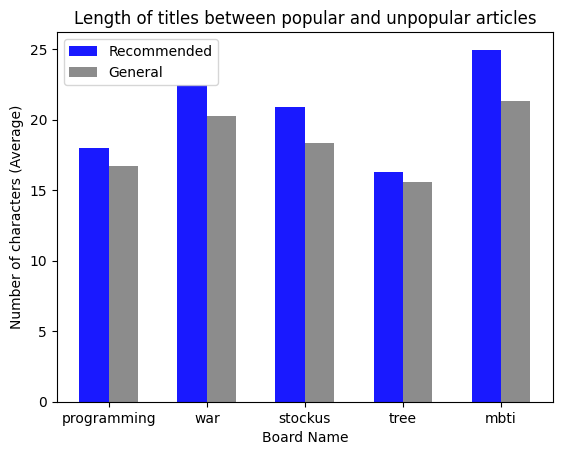

In [13]:
bar_width = 0.3
alpha = 0.9
w = 0.15

plt.bar(index_list - w, len_by_board_rec, width = bar_width, alpha = alpha, label="Recommended", color="blue") #그래프 그리기
plt.bar(index_list + w, len_by_board_gen, width = bar_width, alpha = alpha, label="General", color="gray")
plt.xticks(index_list, [Site[i][0] for i in range(5)], rotation = 0)

plt.title('Length of titles between popular and unpopular articles')
plt.legend(loc='upper left')
plt.ylabel('Number of characters (Average)')
plt.xlabel('Board Name')




### <b style="color:blue">가설 2</b> : 인기글 중에서, 제목에 한글 축약어(ex.ㅋㅋ, ㄹㅇ, ㄷ)가 들어간 인기글은 다른 인기글에 비해 조회수(추천수)가 상대적으로 높을 것이다.

- 이를 알아보기 위해, 제목에 한글 축약어가 있는 인기글과 아닌 인기글의 조회도 및 추천수 분포를 산점도로 나타내었다.

Text(0.5, 1.0, 'Distribution of Views by KRParticle Presence')

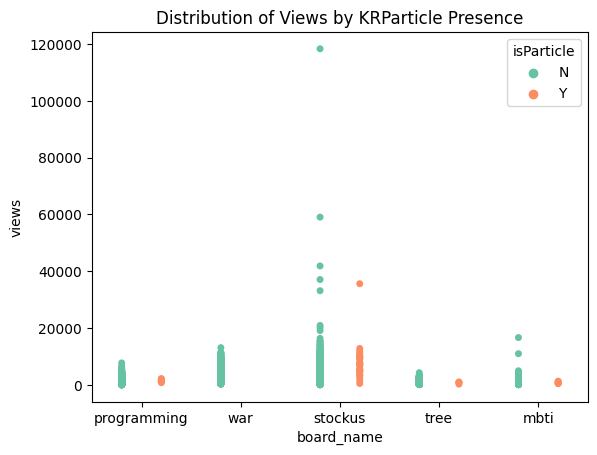

In [14]:
sbn.stripplot(x="board_name", y="views", hue="isParticle", data=recommend_total_df, palette="Set2", jitter=False, dodge=True)
plt.title('Distribution of Views by KRParticle Presence')

Text(0.5, 1.0, 'Distribution of Recommended Numbers by KRParticle Presence')

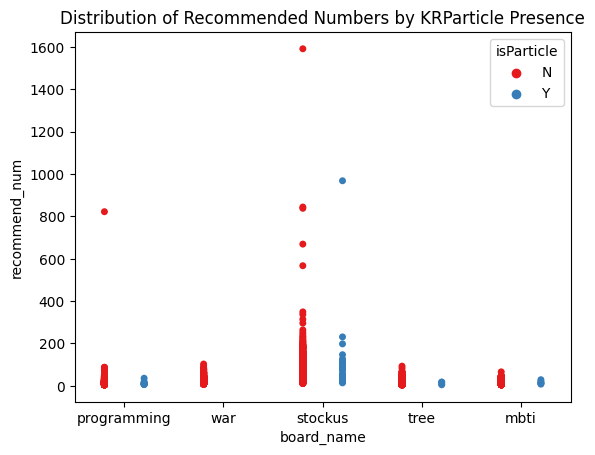

In [15]:
sbn.stripplot(x="board_name", y="recommend_num", hue="isParticle", data=recommend_total_df, palette="Set1", jitter=False, dodge=True)
plt.title('Distribution of Recommended Numbers by KRParticle Presence')

### <b style="color:blue">가설 3</b> : 인기글 중에서, 제목에 수식언(관형사, 부사)의 빈도가 높은 인기글의 조회수(추천수)가 상대적으로 높을 것이다.

- 이를 알아보기 위해, 제목에 들어있는 수식언의 개수에 따른 평균 조회수와 평균 추천수를 막대그래프로 나타내었다.
- 위에서의 분석과는 다르게, 모든 게시판의 글들을 합쳐서 분석을 진행했다. 이는 제목에서, 수식언 개수에 따른 영향은 각 커뮤니티별로 차이가 없을 것이며 합쳐서 분석을 진행하면 더 많은 샘플을 얻을 수 있을 것이라고 생각했기 때문이다.

In [16]:
ad_views = recommend_total_df.groupby("adnum").views.mean()
ad_recs = recommend_total_df.groupby("adnum").recommend_num.mean()
# 전체 게시판의 모든 인기글에서, 조회수 데이터와 추천수 데이터 분리

Text(0.5, 0, 'Number of Adjectives, Determines, and Adverbs')

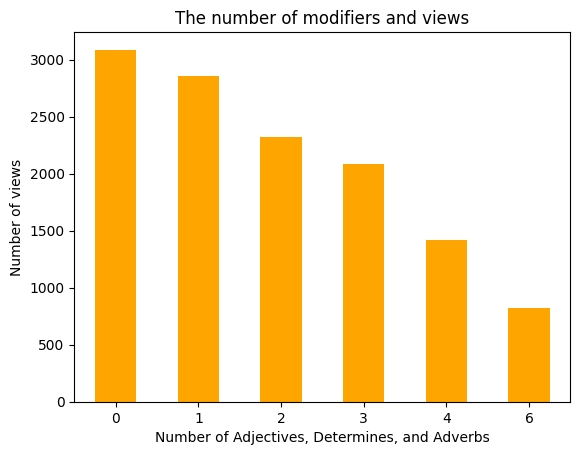

In [17]:
ad_views.plot.bar(color="orange")

plt.title('The number of modifiers and views')
plt.xticks(rotation = 0)
plt.ylabel('Number of views')
plt.xlabel('Number of Adjectives, Determines, and Adverbs')

Text(0.5, 0, 'Number of Adjectives, Determines, and Adverbs')

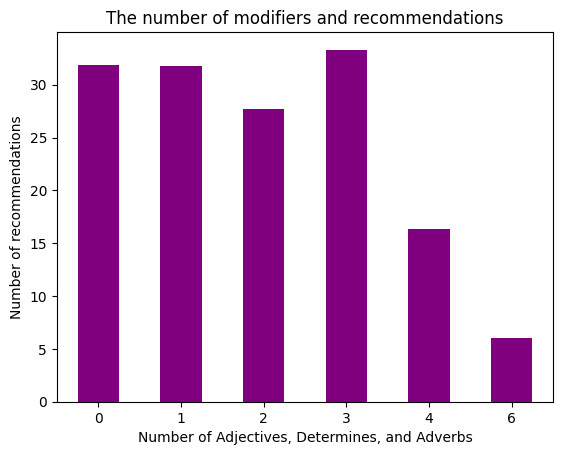

In [18]:
ad_recs.plot.bar(color="purple")

plt.title('The number of modifiers and recommendations')
plt.xticks(rotation = 0)
plt.ylabel('Number of recommendations')
plt.xlabel('Number of Adjectives, Determines, and Adverbs')

### <b style="color:blue">가설 4</b> : 인기글의 제목에 사용된 명사들 중, 많이 사용된 상위 20개의 명사 중에는 부정적(자극적) 어휘가 다수일 것이다.

- 이를 알아보기 위해, 인기글 제목에서 쓰인 명사의 전반적인 분포를 게시판 별로 워드 클라우드 형태로 나타내었다.
- 상위 20개의 명사들은 따로 정리하여 표로 나타냈다.

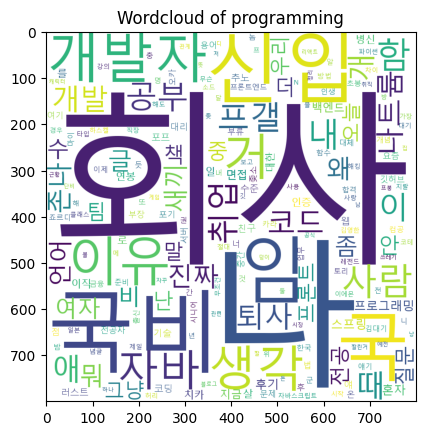

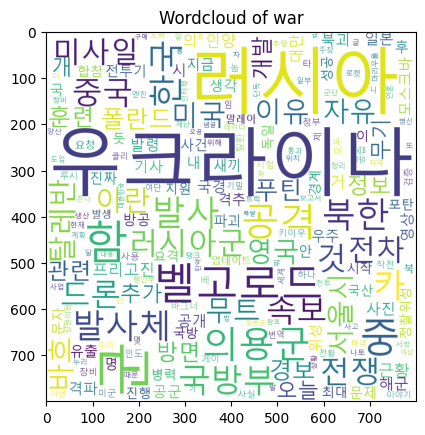

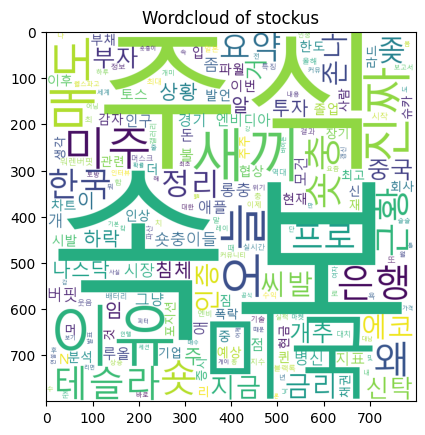

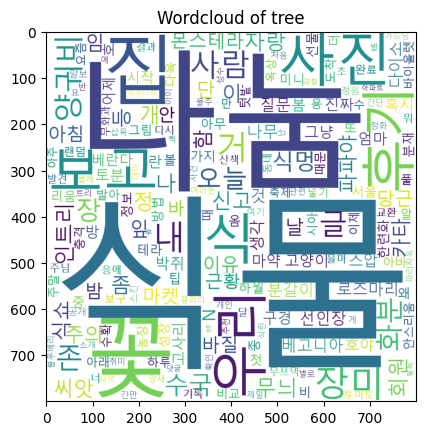

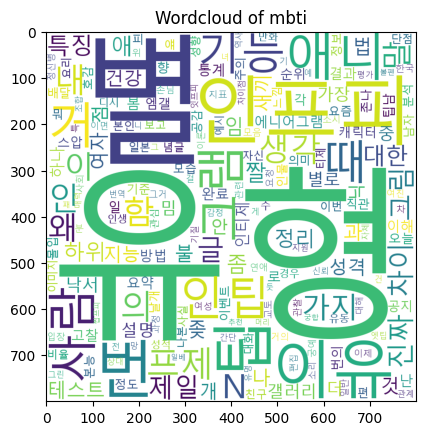

In [19]:
temp_data = []

def show_wordcloud(target_board): #Wordcloud 보이기
    temp_noun_series = recommend_total_df[recommend_total_df["board_name"] == target_board].nouns
    
    word_list=[]
    
    for i in temp_noun_series: #분해
        temp_list = i.split("@")
        for k in temp_list:
            word_list.append(k)
            
    collections = Counter(word_list) #List->Counter
    
    word_cloud = WordCloud(font_path='malgun', width=400, height=400, scale=2.0, max_font_size=200 ,background_color='white')
    generator = word_cloud.generate_from_frequencies(collections)
    
    plt.figure()
    plt.title(f'Wordcloud of {target_board}')
    plt.imshow(generator)
    
    temp_dict = dict(collections)
    temp_dict = sorted(temp_dict, key = lambda n:temp_dict[n], reverse=True)
    
    temp_data.append(temp_dict[:20])
    
for i in range(5):
    show_wordcloud(Site[i][0])
    

In [20]:
print("TOP 20 Words:")
pd.DataFrame(zip(temp_data[0], temp_data[1], temp_data[2], temp_data[3], temp_data[4]), columns=[Site[i][0] for i in range(5)])

TOP 20 Words:


,programming,war,stockus,tree,mbti
0,회사,우크라이나,속보,식물,유형
1,나,러시아,주식,나눔,별
2,국비,군,미국,꽃,인프피
3,신입,함,이유,집,팁
4,국,벨고로드,새끼,사진,번
5,임,중,매도,보고,이유
6,개발자,공격,진짜,우리,애니
7,이유,의용군,오늘,후기,그램
8,생각,북한,미주,식,사람
9,거,발사,은행,장미,거


## 5.결론
### 5-1. 종합
- 가설과는 다르게, <u>인기글은 일반적인 게시글에 비하면 제목의 길이가 상대적으로 긴 경향</u>을 보였다.
- 가설과는 다르게, 제목에 <u>한글 축약어가 포함된 인기글은 아닌 인기글에 비해 조회수가 낮은 경향</u>을 보였다. 이는 게시글의 추천수의 경우에도 마찬가지의 양상을 보였다.
- 가설과는 다르게, <u>인기글의 수식어가 많을 수록 그 조회수가 하락하는 경향</u>을 보였다. 게시글의 추천수의 경우에도 비슷한 양상을 보였으나, 수식어가 3개 들어간 경우 다른 경우에 비해 상대적으로 높은 추천수를 보였다.
- 가설과는 다르게, <u>부정적인 어휘는 제목에서 "다수"를 차지할 정도로 사용되지 않는다.</u> 다만 그 존제 자체는 관찰할 수 있었다.
### 5-2. 추측 및 논의
- 가설 설정 당시, 신문 제목이 간략한 표현을 쓰는 것 처럼 이목을 끌기 위해서는 일반적인 게시글에 비해 인기글은 상대적으로 짧은 제목을 가져야 할것 이라 생각했다. 하지만 인기글에서는 그러한 경향이 나타나지 않았다. 이는  대게 <b>일반적인 게시글은 질문, 잡담 등의 단순한 내용</b>을 담은 경우가 많은 반면 <b>인기글은 사람들의 이목을 끌 만한 주제에 대한 많은 정보</b>를 담은 경우가 많아 <b>제목에서도 그 단순함과 복잡함이 반영된 결과</b>로 생각된다.
- 가설 설정 당시, 한글 축약어(파티클)이 포함된 인기글은 사람들의 이목을 더 잘 끌것이라고 생각했다. 하지만 인기글에서는 그와 반대의 결과(상대적으로 낮은 조회수, 추천수)가 나왔다. 이는 <b>요즘의 사람들이 한글 축약어가 들어간 제목에 대해 흥미를 잘 느끼지 못하는 것이라고 추측</b>해 볼 수 있다.
- 가설 설정 당시, 수식어가 많을 수록 그만큼 제목에 이목이 많이 끌릴 것이라고 생각했다. 하지만 결과는 그와 정 반대로 나왔다. 이는, <b>많은 수식어가 오히려 이목을 끄는데 방해가 된 결과</b>라고 생각된다.
- 가설 설정 당시, 부정적인 어휘의 이목을 끌기 쉬운 특성상 제목에 많이 사용될 것이라고 생각했다. 하지만 결과는 부정적 어휘는 제목에서 많은 부분을 차지하지 않음을 보였다. 다만 그럼에도 일부 부정적 어휘들(ex. \*, 숏\*, 새\*)을 찾아 볼 수 있었는데, 이는 <b>부정적인 어휘가 이목을 끌 수 있음은 유효하나 그것이 이목을 끄는 데에 결정적인 요인은 아님은 추측</b>해 볼 수 있다.

## 참고문헌
- <b>KoNLPy official documentation</b> : https://konlpy.org/ko/latest/index.html